1. x Benchmark Events
-  x Auswahleverteilung iN und hN darstellen für Train, Validation und Test daten
2. MSE für Train, Val und Test vergleichen
- umformen zu RMSE nach invert transform
3. Verteilung für alle ergebnisse
- Boxplot oder Violinenplot
4. Actual vs Fitted
5. (evtl Residuals vs Fitted) könnte nützlich sein um zu schauen bei welchen Wertebereichen welche tendenz besteht
5. MSE der Maximalwerte jedes Ereignisses aus Testdatensatz
- (Zeitliche Verschiebung des Maximalwertes)
6. x Stichproben Plots von Maximalwerten 


In [1]:
%%capture
# Load Relevant Libraries, the model and the test data
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from tensorflow.keras.models import model_from_json
import joblib
import pickle
import os
from modules.sequence_and_normalize import sequence_data, sequence_sample_random, sequence_list
from sklearn.preprocessing import MinMaxScaler
from modules.plots import plot_seq_i_d_Q
from modules.save_load_model import load_model


# Load the model
model_name = 'Gievenbeck_LSTM_Single_1h_P_20240408'
model_folder = os.path.join('05_models', model_name)
# model_folder = os.path.join('05_models', 'Gievenbeck_SingleNode_LSTM_20240328')
model, in_scaler, out_scaler, train_data, val_data, test_data, data_info_dict = load_model(model_folder)


In [2]:
# Load events data
# events_df = pd.read_csv('02_input_data/events_FMO.csv')

# sequence data to list structure
lag = data_info_dict['lag']
delay = data_info_dict['delay']
p_steps = data_info_dict['prediction_steps']

in_vars= data_info_dict['in_vars']
out_vars= data_info_dict['out_vars']

seq_test, seq_test_trans = sequence_list(test_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                  out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)


In [3]:
# Print all Event meta data 
# i=0
# for obj in seq_test_trans:
#     print(i, obj[0])
#     i += 1


0 {'name': 'Gievenbeck_e2_T100D15', 'duration': 20, 'total precipitation': 30.50000762939453, 'max intensity': 214.80009765625, 'interval': 5, 'event type': 'Euler Typ 2', 'lag': 24, 'delay': -12, 'prediction steps': 12}
1 {'name': 'Gievenbeck_e2_T5D1080', 'duration': 1085, 'total precipitation': 49.8499881029129, 'max intensity': 106.82398529052735, 'interval': 5, 'event type': 'Euler Typ 2', 'lag': 24, 'delay': -12, 'prediction steps': 12}
2 {'name': 'Gievenbeck_2023-08-02 21 05 00_hN20 21', 'duration': 575, 'total precipitation': 20.20999278128147, 'max intensity': 13.896001052856445, 'interval': 5, 'event type': 'Aufgezeichnet', 'lag': 24, 'delay': -12, 'prediction steps': 12}
3 {'name': 'Gievenbeck_e2_T2D30', 'duration': 35, 'total precipitation': 15.299991289774576, 'max intensity': 86.15992546081543, 'interval': 5, 'event type': 'Euler Typ 2', 'lag': 24, 'delay': -12, 'prediction steps': 12}
4 {'name': 'Gievenbeck_2023-07-09 16 30 00_hN17 94', 'duration': -20, 'total precipitati

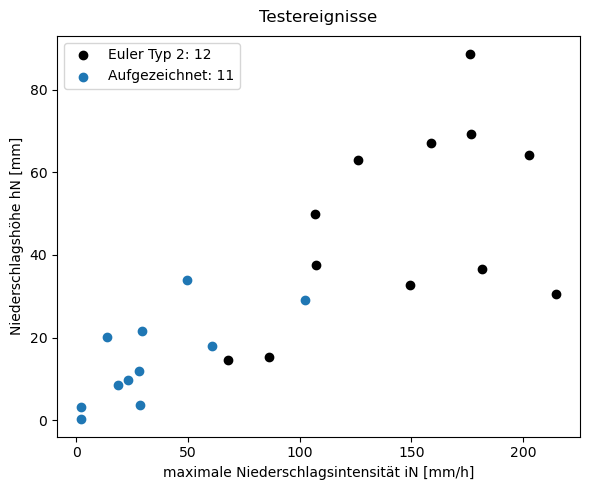

In [4]:
# Extract total precipitation and max intensity from seq_test
e2_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']
e2_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']

aufgezeichnet_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']
aufgezeichnet_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.plot( e2_intensity, e2_precipitation,'o', color='black', label='Sample')
ax2.scatter(aufgezeichnet_intensity, aufgezeichnet_precipitation, marker='o',  label='Events')
ax2.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Testereignisse', pad=10)
ax2.legend(labels=['Euler Typ 2: {}'.format(len(e2_precipitation)), 'Aufgezeichnet: {}'.format(len(aufgezeichnet_precipitation))])
plt.tight_layout()


In [5]:
# in_col=1
# out_col=2
# # Keep track of original shapes of in and out data
# in_original_shape = [sample[in_col].shape for sample in seq_test]  
# in_concat = np.concatenate([np.array(sample[in_col]) for sample in seq_test])
# in_concat = np.concatenate([np.array(sequence) for sequence in in_concat])
# # in_concat_flattened = np.reshape(in_concat, (in_concat.shape[0], -1, in_concat.shape[2]))

# out_original_shape = [sample[out_col].shape for sample in seq_test]

# out_concat = np.concatenate([sample[2].reshape(sample[2].shape[0], -1) for sample in seq_test])

# # out_concat = np.concatenate([np.array(sample[out_col]) for sample in seq_test])

# print(in_concat)

# in_invert = in_scaler.inverse_transform(in_concat)
# out_invert = out_scaler.inverse_transform(out_concat)



In [6]:
# # Reshape in_concat back to original shape
# in_invert = np.split(in_concat, np.cumsum([np.prod(shape) for shape in in_original_shape[:-1]]))
# in_invert = [sample.reshape(shape) for sample, shape in zip(in_invert, in_original_shape)]


# # Reshape out_concat back to original shape
# out_invert = np.split(out_concat, np.cumsum([np.prod(shape) for shape in out_original_shape[:-1]]))
# out_invert = [sample.reshape(shape) for sample, shape in zip(out_invert, out_original_shape)]

# seq_test_invert = [(seq_test[i][0], in_invert[i], out_invert[i]) for i in range(len(seq_test))]

# # # Check if the sum of the columns is the same to verify reshaping works properly
# # col_1_sum_seq_test_invert = sum([np.sum(sample[1]) for sample in seq_test_invert])
# # col_1_sum_seq_test = sum([np.sum(sample[1]) for sample in seq_test])
# # col_2_sum_seq_test_invert = sum([np.sum(sample[2]) for sample in seq_test_invert])
# # col_2_sum_seq_test = sum([np.sum(sample[2]) for sample in seq_test])
# # is_same_sum = col_1_sum_seq_test_invert == col_1_sum_seq_test
# # is_same_sum_2 = col_2_sum_seq_test_invert == col_2_sum_seq_test
# # print(is_same_sum, is_same_sum_2)


595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0016 - mae: 0.0098 - mape: 21014.8867 - mse: 0.0016
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 - mae: 0.0103 - mape: 21772.2109 - mse: 0.0017
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - mae: 0.0113 - mape: 24663.4883 - mse: 0.0021
MSE Training:  0.00145
MSE Validierung:  0.00132
MSE Test:  0.00178


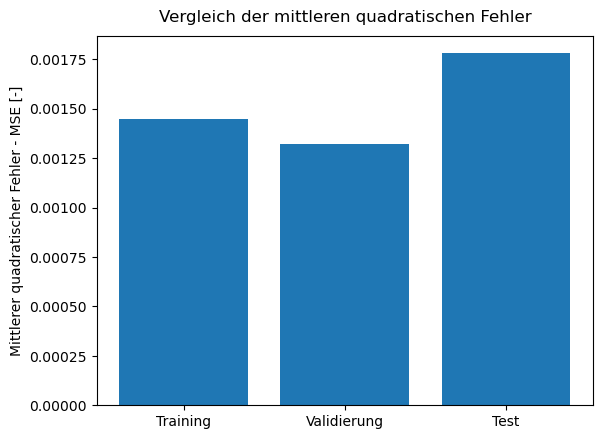

In [28]:
x_train, y_train = sequence_data(train_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)
x_val, y_val = sequence_data(val_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)
x_test, y_test = sequence_data(test_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)

eval_train = model.evaluate(x_train, y_train , verbose=1)
eval_val = model.evaluate(x_val, y_val , verbose=1)
eval_test = model.evaluate(x_test, y_test , verbose=1)
mse_train = round(eval_train[0],5)
mse_val = round(eval_val[0],5)
mse_test = round(eval_test[0],5)

mse = (mse_train, mse_val, mse_test)
# Evaluation metric names
print('MSE Training: ', mse_train )
print('MSE Validierung: ', mse_val)
print('MSE Test: ', mse_test)
# Bar plot
plt.title('Vergleich der mittleren quadratischen Fehler', pad=10)
plt.bar(['Training', 'Validierung', 'Test'], mse)
plt.ylabel('Mittlerer quadratischer Fehler - MSE [-]')

# Show the plot
plt.show()

# calculate residuals and plot the distribution

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


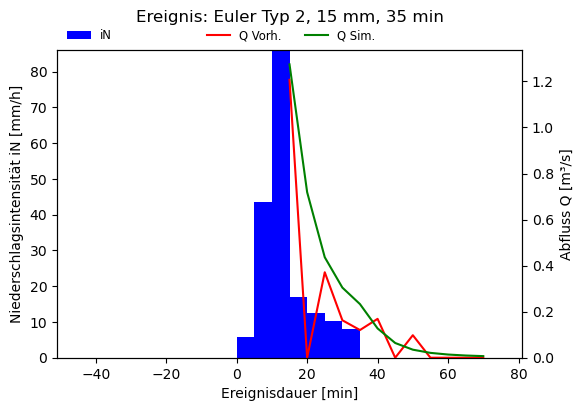

In [7]:
# test for plot_seq_i_d_Q function
n_sample = 3
n = 15
interval = seq_test[n_sample][0]['interval']
meta = seq_test[n_sample][0]
in_seq = seq_test[n_sample][1][n]
out_act = seq_test[n_sample][2][n]

# Calculate the start and end time of the sequence so that a duration column can be created
start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
end_time = start_time + p_steps * interval
duration_col = np.arange(start_time, end_time, interval)

Predict = model.predict(seq_test_trans[n_sample][1])
Predict_invert = out_scaler.inverse_transform(Predict)

predict_seq = np.column_stack((duration_col,Predict_invert[n]))
actual_seq = np.column_stack((duration_col,out_act))


plot_seq_i_d_Q(in_seq, actual_seq, predict_seq, meta, interval,).show()

In [11]:
len(seq_test[3][1]) * 5 - 240
# max_index

30

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


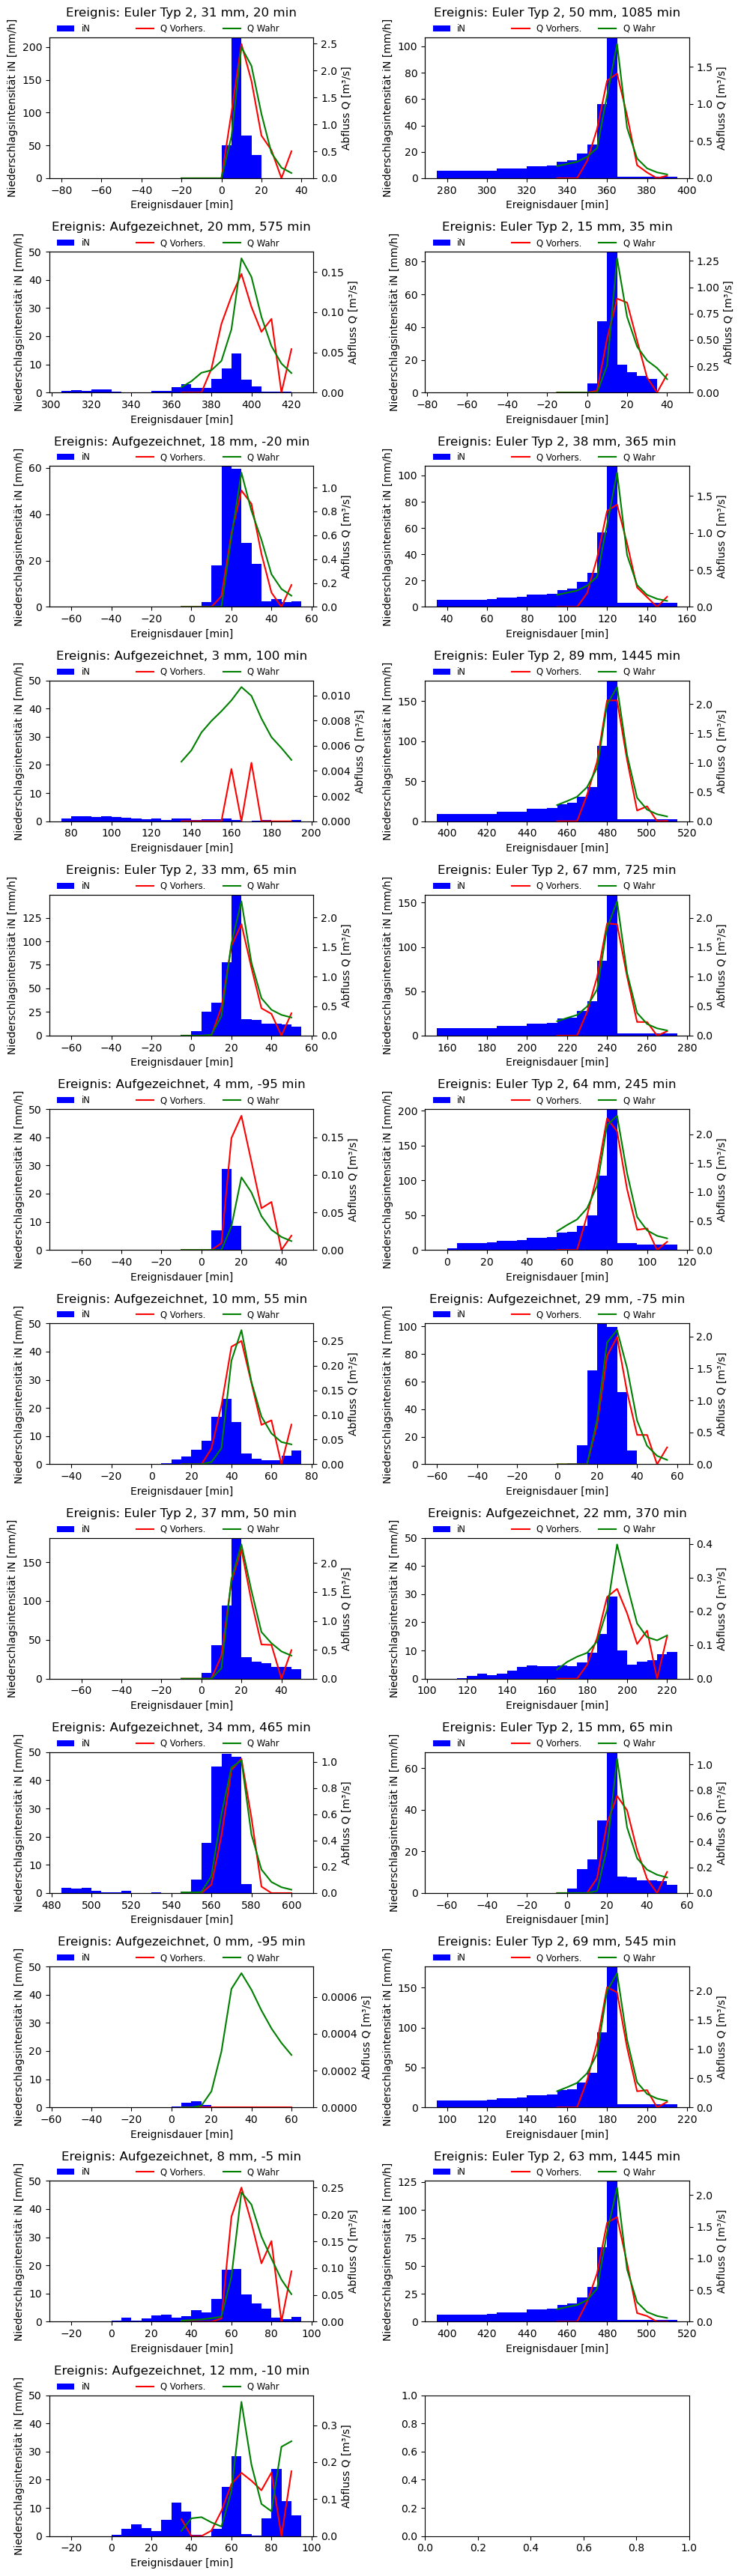

In [9]:
# make this a function that takes event_data =seq_test[n_sample], event_data_trans, n_seq = n,  interval, delay, p_steps, duration_col

# Specify what the column index of the duration data in the input data is
# duration_col = int(0)
#retrieve the interval of the time steps
interval = seq_test[0][0]['interval']  

# Create a grid of subplots
plot_rows = int(len(seq_test_trans)/2+1)
fig, axs = plt.subplots(plot_rows, 2, figsize=(10, 1.5*len(seq_test_trans)))

# Loop through n_sample
for n_sample in range(len(seq_test_trans)):
    # n = 12 +int((len(seq_test[n_sample][1])-24) / 3)
    # n = int(len(seq_test[n_sample][1]) / 5)
    n = np.argmax(seq_test[n_sample][2][:, 0, 0])
    n = n - p_steps/2
    n = n.astype(int)

    # Calculate the start and end time of the sequence so that a duration column can be created
    start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
    end_time = start_time + p_steps * interval
    duration_col = np.arange(start_time, end_time, interval)

    Predict = model.predict(seq_test_trans[n_sample][1])
    Predict_invert = out_scaler.inverse_transform(Predict)
        
    predict_seq = np.column_stack((duration_col,Predict_invert[n]))
    actual_seq = np.column_stack((duration_col,seq_test[n_sample][2][n]))
    
    ''' 
    To do: - why is precipitation always min 1??
    '''
    
    # Dictionary of event meta data
    meta = seq_test[n_sample][0] #'name': sample_name, 'duration': event_duration, 'total precipitation': precip_sum, 'max intensity': max_intensity, 'interval': intervall, 'Ereignis': type


    # Calculate column index for the subplot. Only important for plot!!
    col_index = n_sample % 2

    
    # Create Barplot of Precipitation
    ax1 = axs[n_sample // 2, col_index]
    ax1.set_title(f"Ereignis: {meta['event type']}, {round(meta['total precipitation'])} mm, {meta['duration']} min", pad=20)
    x = seq_test[n_sample][1][n][:,0]  # Set x-axis values
    ax1.bar(x, seq_test[n_sample][1][n][:,1], color='blue', label='iN', width=interval, align='edge')
    top_lim = max(max(seq_test[n_sample][1][n][:,1]), 50)
    ax1.set_ylim(bottom=0, top=top_lim)  # Set y-axis to start from zero
    ax1.set_ylabel('Niederschlagsintensität iN [mm/h]')
    ax1.set_xlabel('Ereignisdauer [min]')
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.15), frameon=False, fontsize = 'small')

    # Create a twin axis on the right side
    # Plotting the predicted and actual values in the corresponding subplot
    ax2 = ax1.twinx()
    ax2.plot(predict_seq[:, 0], predict_seq[:, 1], color = 'red', label='Q Vorhers.')
    ax2.plot(actual_seq[:, 0], actual_seq[:, 1], color = 'green', label='Q Wahr')
    ax2.set_ylim(bottom=0)  # Set y-axis to start from zero
    ax2.set_ylabel('Abfluss Q [m³/s]')
    ax2.legend(loc='upper left', bbox_to_anchor=(0.3,1.15), frameon=False, ncol = 2, fontsize = 'small')


    # ax2.legend(loc=1, borderaxespad=1.)
    # ax2.add_artist(legend_1)


plt.tight_layout()
# Show the plot
plt.show()
